In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import time

In [2]:
# Constants (from the paper)
P0 = 0.58  # Base probability of fire spread
C1 = 0.045  # Wind speed coefficient
C2 = 0.131  # Wind direction coefficient
A = 0.078   # Elevation coefficient

In [3]:
# State Definitions
EMPTY = 0  # No vegetation
VEGETATION = 1  # Vegetation present but not burning
BURNING = 2  # Actively burning
BURNED = 3  # Completely burned

In [4]:
# Define Moore Neighborhood (8 neighbors)
NEIGHBORHOOD = [(-1, -1), (-1, 0), (-1, 1),
                 (0, -1),  (0, 1),
                 (1, -1),  (1, 0), (1, 1)]

In [44]:
from matplotlib.colors import ListedColormap
c_map = ListedColormap(['black', 'green', 'yellow', 'white'])
c_map.set_bad(color='black')

# Simple Model
## Assume constant Pveg, Pden, Slope

In [45]:
def calculate_fire_probability(p0, p_veg, p_den, wind_speed, wind_dir, terrain_slope, fire_dir):
    """Calculate probability of fire spreading based on factors"""
    theta = np.cos(np.deg2rad(abs(wind_dir - fire_dir)))  # Wind alignment
    P_w = np.exp(C1 * wind_speed) * np.exp(C2 * wind_speed * (theta - 1))  # Wind effect
    P_ele = np.exp(A * terrain_slope)  # Elevation effect
    return p0 * (1 + p_veg) * (1 + p_den) * P_w * P_ele

def initialize_forest(grid_size, density=0.6):
    """Initialize the forest with vegetation and empty spaces"""
    grid = np.random.choice([VEGETATION, EMPTY], size=grid_size, p=[density, 1-density])
    return grid

def ignite_fire(grid, ignition_point):
    """Start the fire at the given ignition point"""
    x, y = ignition_point
    grid[x, y] = BURNING
    return grid

def simulate_fire(grid, steps=50):
    """Simulate wildfire propagation over time"""
    rows, cols = grid.shape
    for step in range(steps):
        new_grid = np.copy(grid)
        for x in range(1, rows - 1):
            for y in range(1, cols - 1):
                if grid[x, y] == BURNING:
                    new_grid[x, y] = BURNED  # Burn out
                    for dx, dy in NEIGHBORHOOD:
                        nx, ny = x + dx, y + dy
                        if grid[nx, ny] == VEGETATION:
                            # Assume a basic terrain and wind data (can integrate real data)
                            wind_speed, wind_dir = 5.7, 310  # Example values
                            terrain_slope = 5  # Example slope in degrees
                            p_veg, p_den = 0.3, 0.3  # Example vegetation & density factors
                            fire_dir = np.degrees(np.arctan2(dy, dx))  # Spread direction

                            P_burn = calculate_fire_probability(P0, p_veg, p_den, wind_speed, wind_dir, terrain_slope, fire_dir)
                            
                            if np.random.rand() < P_burn:
                                new_grid[nx, ny] = BURNING  # Fire spreads

        grid = np.copy(new_grid)
        plt.imshow(grid, cmap=c_map, interpolation='nearest')
        plt.title(f"Step: {step+1}")
        plt.pause(0.1)

    plt.show()

In [46]:
# Simulation Parameters
GRID_SIZE = (50, 50)  # Grid size
IGNITION_POINT = (25, 25)  # Fire start point

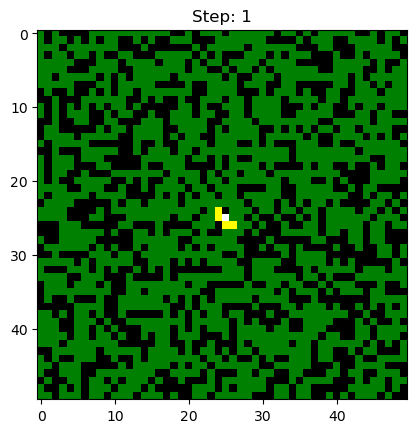

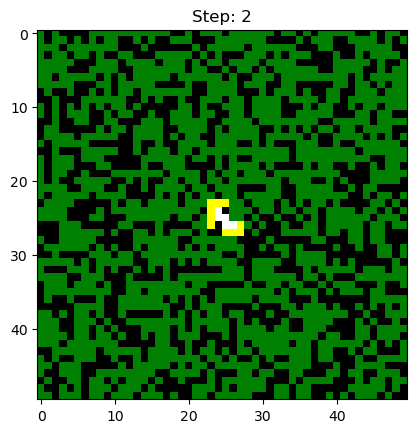

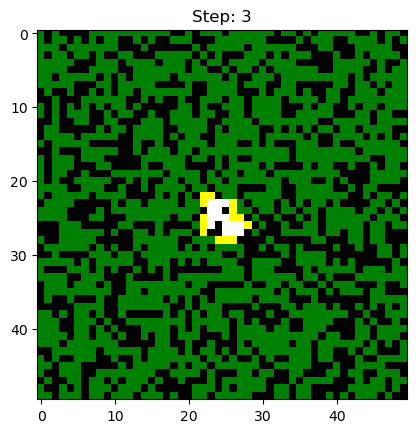

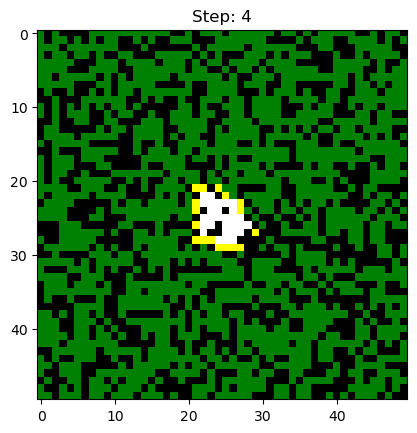

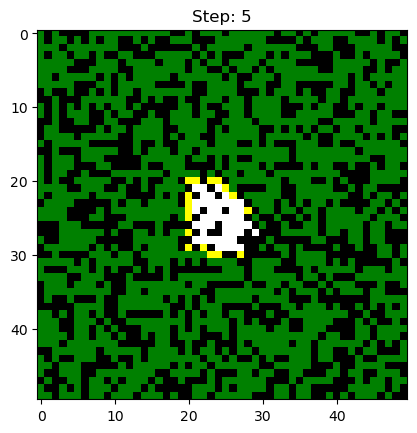

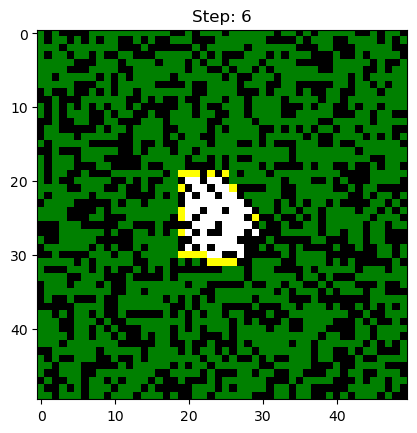

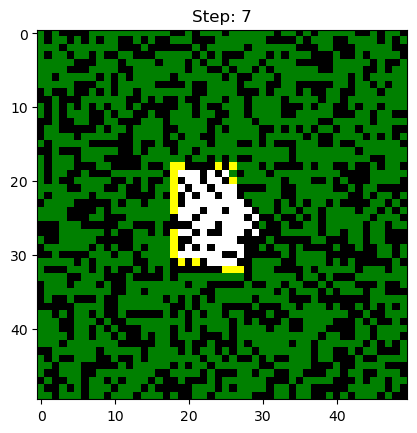

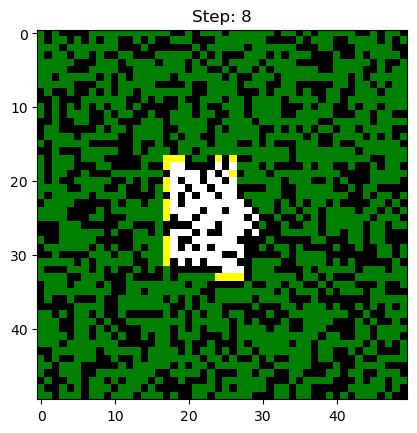

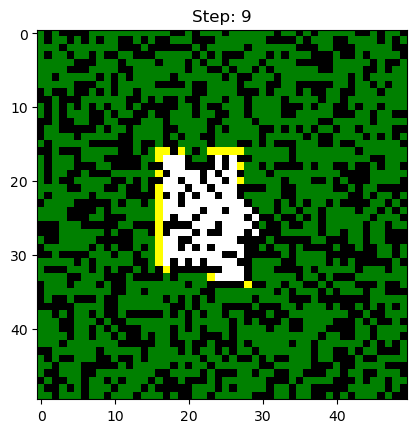

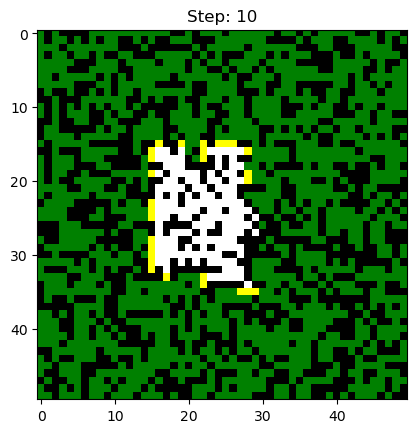

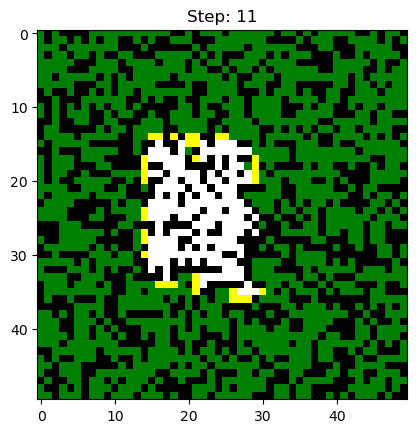

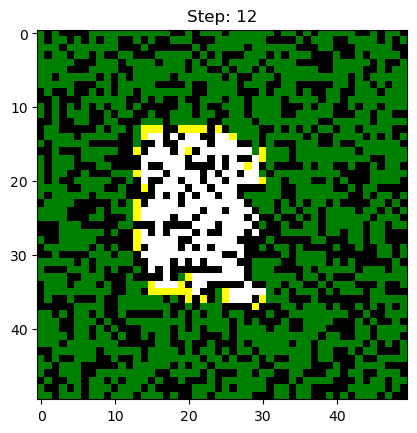

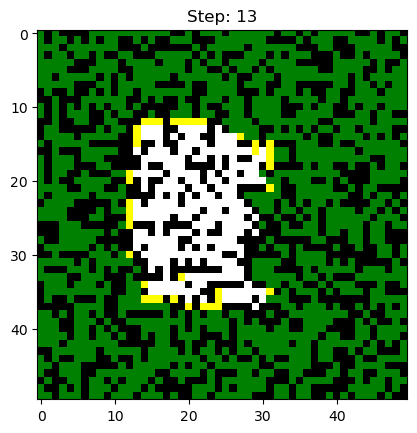

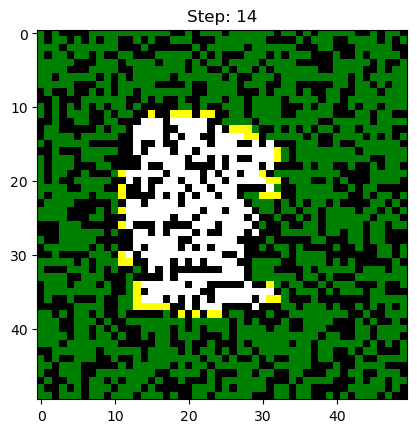

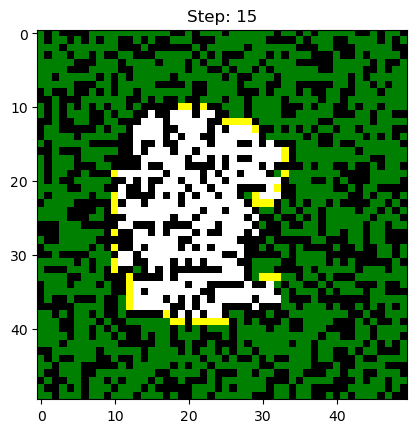

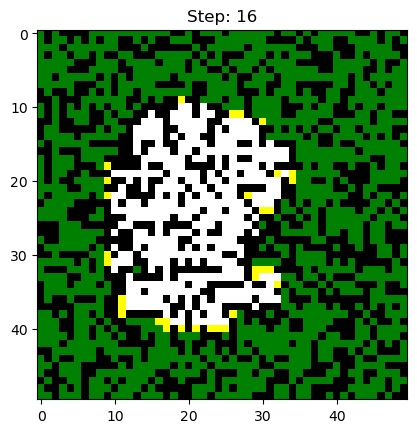

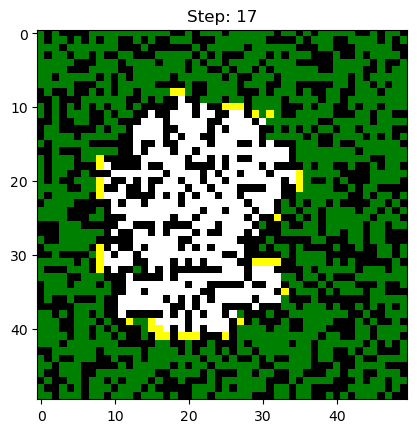

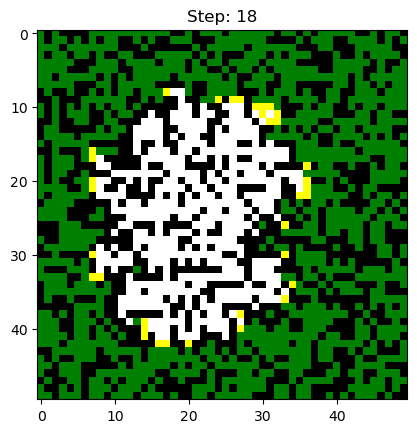

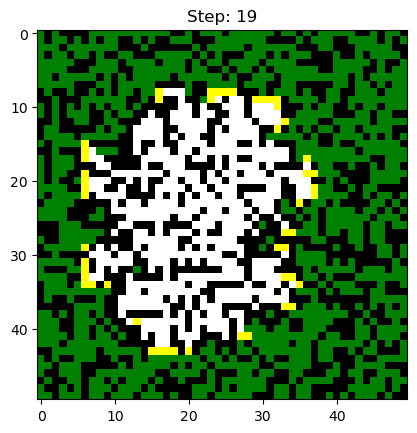

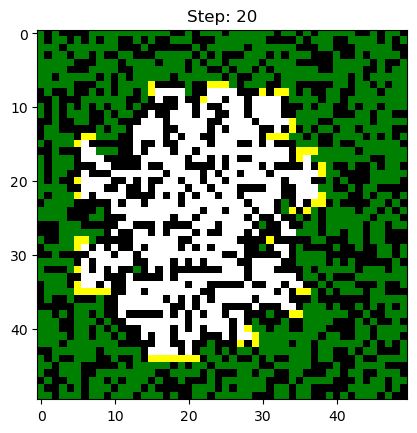

In [47]:
# Initialize and run simulation
forest = initialize_forest(GRID_SIZE)
forest = ignite_fire(forest, IGNITION_POINT)
simulate_fire(forest, steps=20)

# Actual Pele, Pveg
## Get Elevation from Google Map Elevation API and Pveg using Normalized NDVI from Google Earth Engine Imagery

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import time
import os
import rasterio
from skimage.transform import resize

# Constants
P0 = 0.58  # Base fire spread probability
C1 = 0.045  # Wind coefficient (speed)
C2 = 0.131  # Wind coefficient (direction)
A = 0.078   # Elevation coefficient
GRID_SIZE = 50  # Number of grid points in each direction
MILES_TO_METERS = 1609.34  # 1 mile = 1609.34 meters
RADIUS_METERS = 3 * MILES_TO_METERS  # 10 miles in meters
LAT_CENTER, LON_CENTER = 34.072382, -118.601048  # Simulation center

# Wind (Assumed Constant)
WIND_SPEED = 8  # m/s
WIND_DIRECTION = 315  # Degrees (North-West)

# States
EMPTY = 0
VEGETATION = 1
BURNING = 2
BURNED = 3

# Google Elevation API
GOOGLE_ELEVATION_API = "https://maps.googleapis.com/maps/api/elevation/json"

# Load API Key from config.json
def load_api_keys(config_file="../config.json"):
    if not os.path.exists(config_file):
        raise FileNotFoundError(f"Config file '{config_file}' not found. Create one with your API keys.")
    with open(config_file, "r") as file:
        return json.load(file)

# Load Google Maps API Key
config = load_api_keys()
GOOGLE_API_KEY = config["google_maps_api_key"]

def get_elevation(lat, lon):
    """Fetch elevation from Google Maps API"""
    params = {'locations': f"{lat},{lon}", 'key': GOOGLE_API_KEY}
    response = requests.get(GOOGLE_ELEVATION_API, params=params).json()
    if 'results' in response and response['results']:
        return response['results'][0]['elevation']
    return 0

def generate_grid(center_lat, center_lon, grid_size, radius_meters):
    """Generate a grid of lat/lon points within the specified radius"""
    grid = np.zeros((grid_size, grid_size))
    lat_step = (radius_meters * 2) / grid_size / MILES_TO_METERS * 0.0145
    lon_step = lat_step / np.cos(np.radians(center_lat))
    
    lat_grid = np.linspace(center_lat - lat_step * (grid_size // 2), 
                           center_lat + lat_step * (grid_size // 2), grid_size)
    lon_grid = np.linspace(center_lon - lon_step * (grid_size // 2), 
                           center_lon + lon_step * (grid_size // 2), grid_size)

    elevations = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            elevations[i, j] = get_elevation(lat_grid[i], lon_grid[j])
            time.sleep(0.05)  # Avoid exceeding API rate limits

    return lat_grid, lon_grid, elevations

def compute_slope(elevations):
    """Compute slope using elevation differences"""
    slope = np.zeros_like(elevations)
    for i in range(1, elevations.shape[0] - 1):
        for j in range(1, elevations.shape[1] - 1):
            dz_dx = (elevations[i + 1, j] - elevations[i - 1, j]) / 2
            dz_dy = (elevations[i, j + 1] - elevations[i, j - 1]) / 2
            slope[i, j] = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))  # Slope angle in radians
    return np.degrees(slope)  # Convert to degrees

def load_ndvi_and_compute_pveg(ndvi_path, grid_size):
    """Load NDVI GeoTIFF and resample it to match the wildfire simulation grid"""
    with rasterio.open(ndvi_path) as src:
        ndvi = src.read(1)  # Read NDVI band

    # Normalize NDVI to range [0, 1]
    Pveg = (ndvi - np.min(ndvi)) / (np.max(ndvi) - np.min(ndvi))

    # Resample NDVI to match the wildfire simulation grid size
    Pveg_resampled = resize(Pveg, (grid_size, grid_size), mode='reflect', anti_aliasing=True)

    return Pveg_resampled

def calculate_fire_probability(p0, p_veg, p_den, wind_speed, wind_dir, terrain_slope, fire_dir):
    """Calculate probability of fire spreading"""
    theta = np.cos(np.deg2rad(abs(wind_dir - fire_dir)))  # Wind alignment
    P_w = np.exp(C1 * wind_speed) * np.exp(C2 * wind_speed * (theta - 1))  # Wind effect
    P_ele = np.exp(A * terrain_slope)  # Elevation effect
    return p0 * (1 + p_veg) * (1 + p_den) * P_w * P_ele

def initialize_forest(grid_size, vegetation_density=0.7):
    """Initialize vegetation randomly"""
    return np.random.choice([VEGETATION, EMPTY], size=(grid_size, grid_size), p=[vegetation_density, 1 - vegetation_density])

def ignite_fire(grid):
    """Start fire at the center"""
    mid = grid.shape[0] // 2
    grid[mid, mid] = BURNING
    return grid

def plot_fire_simulation(grid, Pveg, step):
    """Plot the wildfire grid with custom colors."""
    # Create a colormap
    cmap = np.zeros((grid.shape[0], grid.shape[1], 3))

    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            if grid[x, y] == EMPTY:
                cmap[x, y] = [0, 0, 0]  # Black
            elif grid[x, y] == VEGETATION:
                cmap[x, y] = [0, Pveg[x, y], 0]  # Green varies with Pveg
            elif grid[x, y] == BURNING:
                cmap[x, y] = [1, 0.84, 0]  # Yellow
            elif grid[x, y] == BURNED:
                cmap[x, y] = [1, 1, 1]  # White

    plt.imshow(cmap)
    plt.title(f"Step: {step+1}")
    plt.pause(0.1)

def simulate_fire(grid, elevations, Pveg, steps=50):
    """Simulate wildfire propagation"""
    slope = compute_slope(elevations)
    for step in range(steps):
        new_grid = np.copy(grid)
        for x in range(1, grid.shape[0] - 1):
            for y in range(1, grid.shape[1] - 1):
                if grid[x, y] == BURNING:
                    new_grid[x, y] = BURNED
                    for dx, dy in [(-1, -1), (-1, 0), (-1, 1),
                                   (0, -1), (0, 1),
                                   (1, -1), (1, 0), (1, 1)]:
                        nx, ny = x + dx, y + dy
                        if grid[nx, ny] == VEGETATION:
                            fire_dir = np.degrees(np.arctan2(dy, dx))
                            P_burn = calculate_fire_probability(P0, Pveg[nx, ny], 0.3, WIND_SPEED, WIND_DIRECTION, slope[nx, ny], fire_dir)
                            if np.random.rand() < P_burn:
                                new_grid[nx, ny] = BURNING

        grid = np.copy(new_grid)
        plot_fire_simulation(grid, Pveg, step)

    plt.show()


In [49]:
# Load NDVI-based Pveg
ndvi_file = "../data/CA_VEG_Sentinel2_NDVI.tif" 
Pveg = load_ndvi_and_compute_pveg(ndvi_file, GRID_SIZE)

In [37]:
# Generate simulation grid
lat_grid, lon_grid, elevations = generate_grid(LAT_CENTER, LON_CENTER, GRID_SIZE, RADIUS_METERS)

In [53]:
# Initialize vegetation and fire
forest_grid = initialize_forest(GRID_SIZE)
forest_grid = ignite_fire(forest_grid)

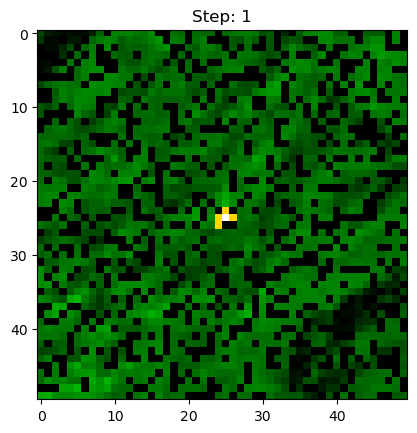

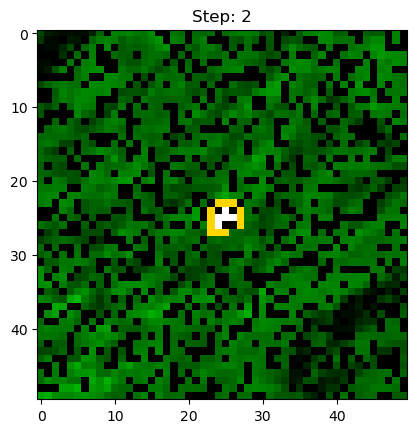

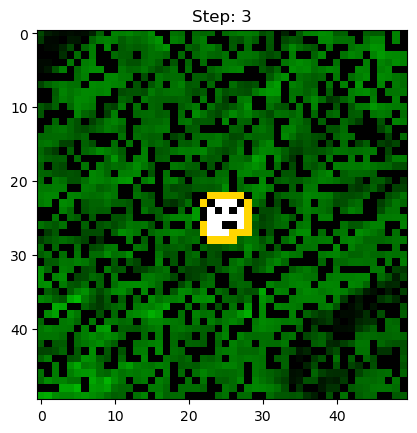

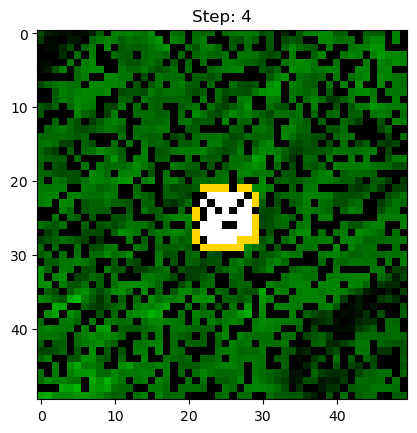

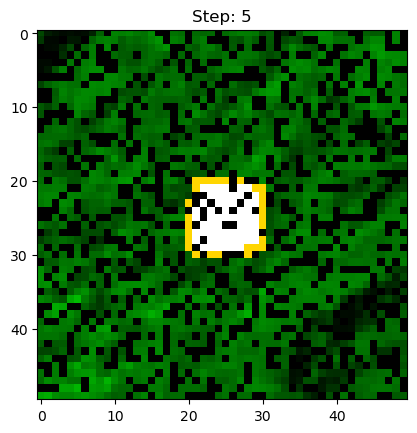

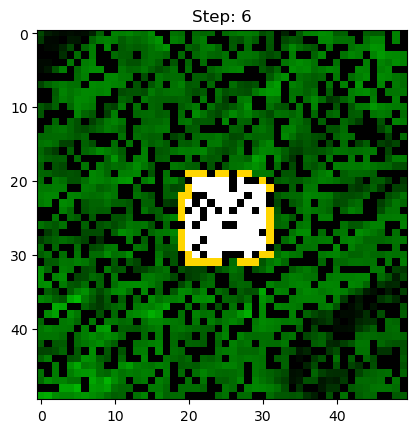

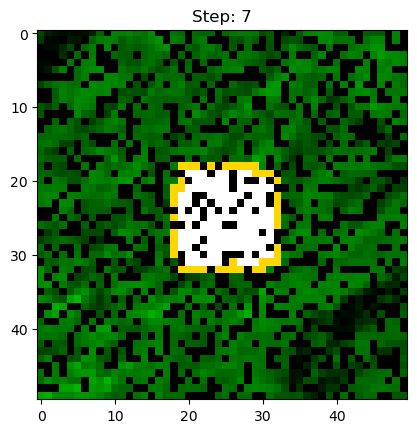

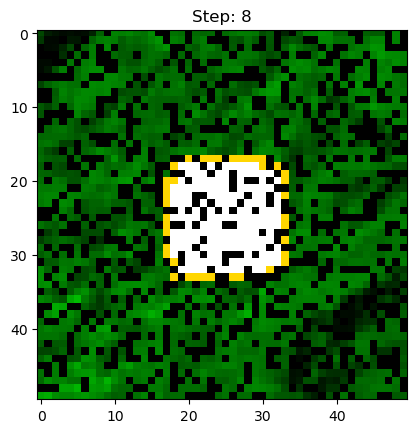

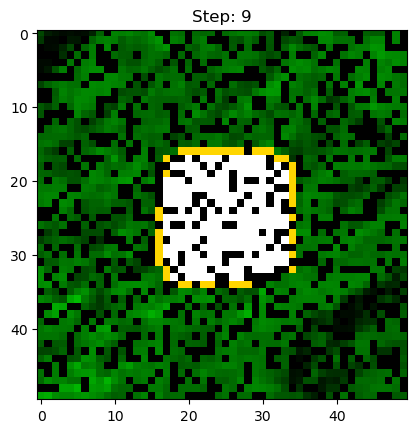

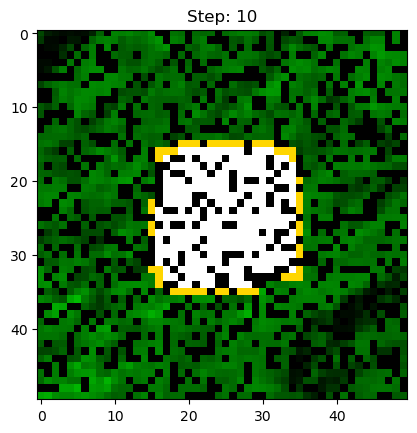

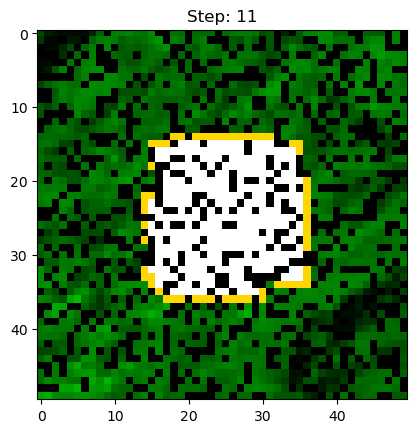

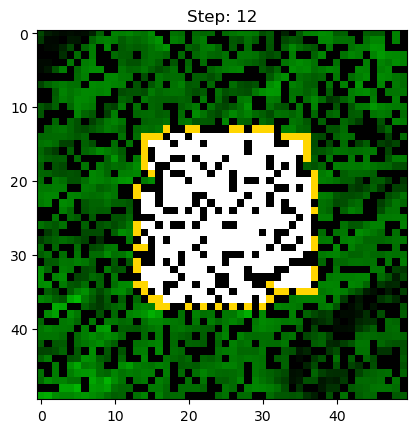

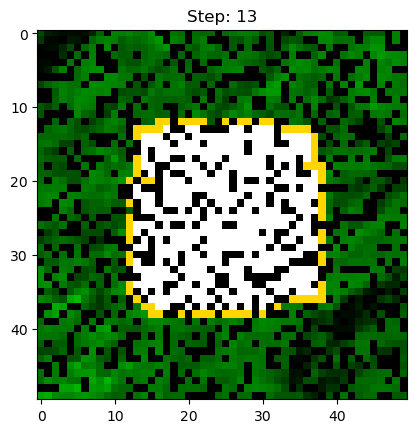

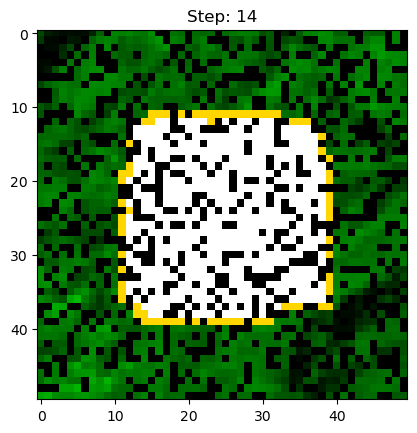

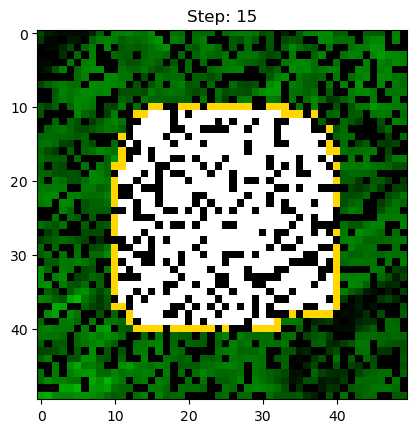

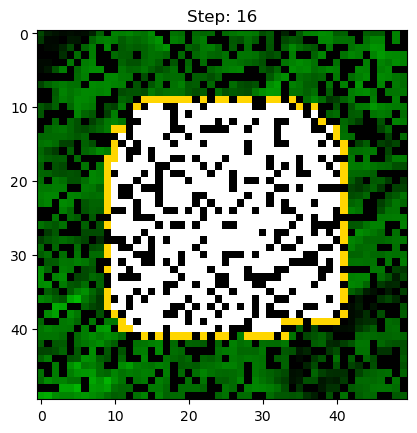

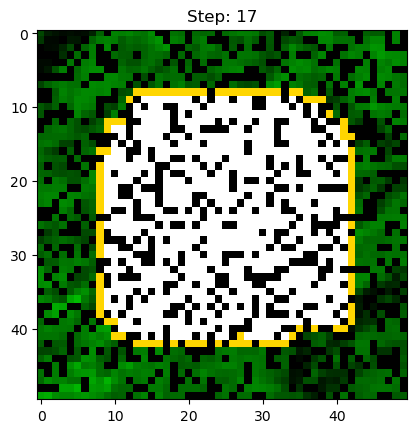

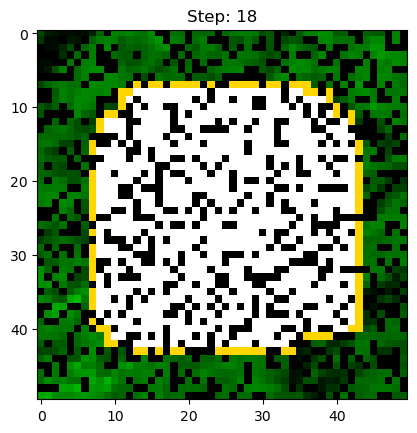

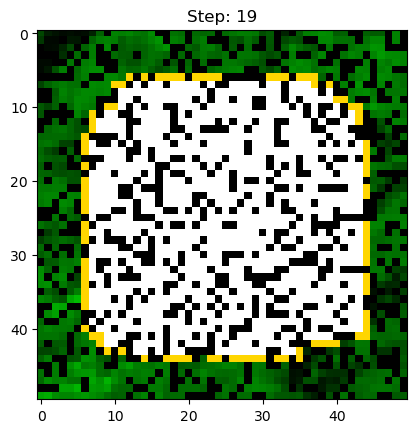

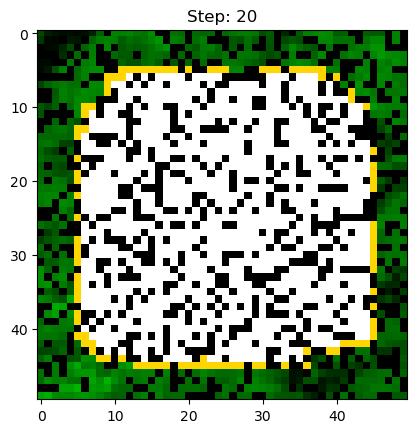

In [54]:
# Run the simulation
simulate_fire(forest_grid, elevations, Pveg, steps=20)